In [1]:
%matplotlib inline
import nltk.data

from gensim.models import word2vec

from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

import pandas as pd
import numpy as np

import os
import re
import logging
import sqlite3
import time
import sys
import multiprocessing
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from itertools import cycle
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/cbrom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
sql_con = sqlite3.connect("/home/cbrom/workspace/2015-02.db")

In [5]:
start = time.time()
sql_data = pd.read_sql("SELECT parent, comment from parent_reply", sql_con)
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 13.37068796157837 secs


In [6]:
total_rows = len(sql_data)
print(total_rows)

4506428


In [7]:
sql_data.head()

,parent,comment
0,&gt; CDBOOT: Cannot boot from CD - Code: 5 new...,Ok will do!
1,Sounds like someone wants some pants jerky,I'm an avid fan of pants meat.
2,"That's definitely a valid point, but I would a...",But where do we draw the line on frequency? An...
3,I feel like Jotaro would like Beat-em-ups more...,In part 6 he starts getting into Octodad
4,I think we've just discovered the fandom's sbu...,Land of Pictures and Text


In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
def clean_text(pairs, out_name):
    start = time.time()
    with open(out_name, 'a', encoding='utf8') as out_file:
        for pos in range(len(pairs)):
            parent = pairs.iloc[pos]['parent'];
            comment = pairs.iloc[pos]['comment']
            
            # remove newlines
            par_no_tabs = str(parent).replace('\t', ' ')
            com_no_tabs = str(comment).replace('\t', ' ')
            
            # normalize to alpha and dot (.)
            par_alpha = re.sub("[^a-zA-Z\.]", " ", par_no_tabs)
            com_alpha = re.sub("[^a-zA-Z\.]", " ", com_no_tabs)
            
            # change multi space to 1
            par_multi_space = re.sub(" +", " ", par_alpha)
            com_multi_space = re.sub(" +", " ", com_alpha)
            
            # stripe 
            par_strip = par_multi_space.strip()
            com_strip = com_multi_space.strip()
            
            # lowercase
            par_clean = par_strip.lower()
            com_clean = com_strip.lower()
            
            # tokenize
            par_sents = tokenizer.tokenize(par_clean)
            par_sents = [re.sub("[\.]", "", par_sent) for par_sent in par_sents]
            com_sents = tokenizer.tokenize(com_clean)
            com_sents = [re.sub("[\.]", "", com_sent) for com_sent in com_sents]
            
            if len(par_clean) > 0 and par_clean.count(' ') > 0:
                for par_sent in par_sents:
                    out_file.write("%s\n" % par_sent)
            
            if len(com_clean) > 0 and com_clean.count(' ') > 0:
                for com_sent in com_sents:
                    out_file.write("%s\n" % com_sent)
                
            if pos % 50000 == 0:
                total_time = time.time() - start
                sys.stdout.write(
                    'Completed ' + 
                    str(round(100 * (pos/total_rows), 2)) + 
                    '% - ' + str(pos) + 
                    ' rows in time ' + 
                    str(round(total_time / 60, 0)) + 
                    ' min & ' + 
                    str(round(total_time % 60, 2)) + 
                    ' secs\r')
        out_file.flush()
                

In [10]:
start = time.time();
clean_comments = clean_text(sql_data, '/home/cbrom/workspace/full.txt')
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 1501.583257675171 secs time 25.0 min & 59.54 secs


In [15]:
start = time.time();

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100;    # Dimensionality of the hidden layer representation
min_word_count = 40;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...")
model = word2vec.Word2Vec(word2vec.LineSentence('/home/cbrom/workspace/full.txt'), workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# We don
# Save the model
model_name = "model_full_reddit";
model.save(model_name) #t plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);


print('Total time: ' + str((time.time() - start)) + ' secs')

2019-01-27 15:40:57,642 : INFO : collecting all words and their counts


Training model...


2019-01-27 15:40:57,764 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-27 15:40:57,900 : INFO : PROGRESS: at sentence #10000, processed 147567 words, keeping 14145 word types
2019-01-27 15:40:57,974 : INFO : PROGRESS: at sentence #20000, processed 299476 words, keeping 21119 word types
2019-01-27 15:40:58,057 : INFO : PROGRESS: at sentence #30000, processed 445878 words, keeping 26416 word types
2019-01-27 15:40:58,114 : INFO : PROGRESS: at sentence #40000, processed 587104 words, keeping 31032 word types
2019-01-27 15:40:58,175 : INFO : PROGRESS: at sentence #50000, processed 732391 words, keeping 34813 word types
2019-01-27 15:40:58,237 : INFO : PROGRESS: at sentence #60000, processed 874063 words, keeping 38249 word types
2019-01-27 15:40:58,300 : INFO : PROGRESS: at sentence #70000, processed 1018155 words, keeping 41400 word types
2019-01-27 15:40:58,398 : INFO : PROGRESS: at sentence #80000, processed 1160915 words, keeping 44083 word types
201

2019-01-27 15:41:02,514 : INFO : PROGRESS: at sentence #720000, processed 10593263 words, keeping 156011 word types
2019-01-27 15:41:02,562 : INFO : PROGRESS: at sentence #730000, processed 10737171 words, keeping 156941 word types
2019-01-27 15:41:02,617 : INFO : PROGRESS: at sentence #740000, processed 10882851 words, keeping 157820 word types
2019-01-27 15:41:02,667 : INFO : PROGRESS: at sentence #750000, processed 11028943 words, keeping 158780 word types
2019-01-27 15:41:02,720 : INFO : PROGRESS: at sentence #760000, processed 11175058 words, keeping 159727 word types
2019-01-27 15:41:02,776 : INFO : PROGRESS: at sentence #770000, processed 11320125 words, keeping 160739 word types
2019-01-27 15:41:02,826 : INFO : PROGRESS: at sentence #780000, processed 11470728 words, keeping 161831 word types
2019-01-27 15:41:02,880 : INFO : PROGRESS: at sentence #790000, processed 11620169 words, keeping 163062 word types
2019-01-27 15:41:02,932 : INFO : PROGRESS: at sentence #800000, processe

2019-01-27 15:41:06,661 : INFO : PROGRESS: at sentence #1430000, processed 21306643 words, keeping 235734 word types
2019-01-27 15:41:06,715 : INFO : PROGRESS: at sentence #1440000, processed 21454831 words, keeping 236575 word types
2019-01-27 15:41:06,774 : INFO : PROGRESS: at sentence #1450000, processed 21600134 words, keeping 237500 word types
2019-01-27 15:41:06,826 : INFO : PROGRESS: at sentence #1460000, processed 21747397 words, keeping 238492 word types
2019-01-27 15:41:06,878 : INFO : PROGRESS: at sentence #1470000, processed 21896959 words, keeping 239462 word types
2019-01-27 15:41:06,941 : INFO : PROGRESS: at sentence #1480000, processed 22048351 words, keeping 240321 word types
2019-01-27 15:41:06,994 : INFO : PROGRESS: at sentence #1490000, processed 22196592 words, keeping 241377 word types
2019-01-27 15:41:07,049 : INFO : PROGRESS: at sentence #1500000, processed 22349633 words, keeping 242283 word types
2019-01-27 15:41:07,098 : INFO : PROGRESS: at sentence #1510000,

2019-01-27 15:41:10,803 : INFO : PROGRESS: at sentence #2140000, processed 32109577 words, keeping 303942 word types
2019-01-27 15:41:10,878 : INFO : PROGRESS: at sentence #2150000, processed 32254864 words, keeping 304679 word types
2019-01-27 15:41:10,939 : INFO : PROGRESS: at sentence #2160000, processed 32400025 words, keeping 305505 word types
2019-01-27 15:41:10,998 : INFO : PROGRESS: at sentence #2170000, processed 32548225 words, keeping 306334 word types
2019-01-27 15:41:11,053 : INFO : PROGRESS: at sentence #2180000, processed 32694917 words, keeping 307063 word types
2019-01-27 15:41:11,107 : INFO : PROGRESS: at sentence #2190000, processed 32843000 words, keeping 307851 word types
2019-01-27 15:41:11,162 : INFO : PROGRESS: at sentence #2200000, processed 32987600 words, keeping 308547 word types
2019-01-27 15:41:11,220 : INFO : PROGRESS: at sentence #2210000, processed 33132965 words, keeping 309367 word types
2019-01-27 15:41:11,296 : INFO : PROGRESS: at sentence #2220000,

2019-01-27 15:41:15,027 : INFO : PROGRESS: at sentence #2850000, processed 42918984 words, keeping 366245 word types
2019-01-27 15:41:15,121 : INFO : PROGRESS: at sentence #2860000, processed 43065119 words, keeping 366909 word types
2019-01-27 15:41:15,176 : INFO : PROGRESS: at sentence #2870000, processed 43213665 words, keeping 367693 word types
2019-01-27 15:41:15,232 : INFO : PROGRESS: at sentence #2880000, processed 43361571 words, keeping 368446 word types
2019-01-27 15:41:15,307 : INFO : PROGRESS: at sentence #2890000, processed 43507877 words, keeping 369086 word types
2019-01-27 15:41:15,370 : INFO : PROGRESS: at sentence #2900000, processed 43650761 words, keeping 369881 word types
2019-01-27 15:41:15,425 : INFO : PROGRESS: at sentence #2910000, processed 43798552 words, keeping 370592 word types
2019-01-27 15:41:15,484 : INFO : PROGRESS: at sentence #2920000, processed 43944347 words, keeping 371250 word types
2019-01-27 15:41:15,537 : INFO : PROGRESS: at sentence #2930000,

2019-01-27 15:41:19,169 : INFO : PROGRESS: at sentence #3560000, processed 53661881 words, keeping 424230 word types
2019-01-27 15:41:19,219 : INFO : PROGRESS: at sentence #3570000, processed 53809860 words, keeping 424991 word types
2019-01-27 15:41:19,272 : INFO : PROGRESS: at sentence #3580000, processed 53956242 words, keeping 425802 word types
2019-01-27 15:41:19,322 : INFO : PROGRESS: at sentence #3590000, processed 54098935 words, keeping 426449 word types
2019-01-27 15:41:19,370 : INFO : PROGRESS: at sentence #3600000, processed 54241278 words, keeping 427085 word types
2019-01-27 15:41:19,422 : INFO : PROGRESS: at sentence #3610000, processed 54388261 words, keeping 427799 word types
2019-01-27 15:41:19,471 : INFO : PROGRESS: at sentence #3620000, processed 54532537 words, keeping 428399 word types
2019-01-27 15:41:19,523 : INFO : PROGRESS: at sentence #3630000, processed 54679448 words, keeping 429119 word types
2019-01-27 15:41:19,573 : INFO : PROGRESS: at sentence #3640000,

2019-01-27 15:41:23,187 : INFO : PROGRESS: at sentence #4270000, processed 64322199 words, keeping 478891 word types
2019-01-27 15:41:23,241 : INFO : PROGRESS: at sentence #4280000, processed 64469582 words, keeping 479570 word types
2019-01-27 15:41:23,312 : INFO : PROGRESS: at sentence #4290000, processed 64616684 words, keeping 480279 word types
2019-01-27 15:41:23,362 : INFO : PROGRESS: at sentence #4300000, processed 64762923 words, keeping 481006 word types
2019-01-27 15:41:23,415 : INFO : PROGRESS: at sentence #4310000, processed 64911339 words, keeping 481693 word types
2019-01-27 15:41:23,468 : INFO : PROGRESS: at sentence #4320000, processed 65058067 words, keeping 482369 word types
2019-01-27 15:41:23,517 : INFO : PROGRESS: at sentence #4330000, processed 65203512 words, keeping 482913 word types
2019-01-27 15:41:23,569 : INFO : PROGRESS: at sentence #4340000, processed 65346465 words, keeping 483597 word types
2019-01-27 15:41:23,618 : INFO : PROGRESS: at sentence #4350000,

2019-01-27 15:41:33,345 : INFO : PROGRESS: at sentence #4980000, processed 74866227 words, keeping 527879 word types
2019-01-27 15:41:34,586 : INFO : PROGRESS: at sentence #4990000, processed 75016755 words, keeping 528463 word types
2019-01-27 15:41:34,664 : INFO : PROGRESS: at sentence #5000000, processed 75163063 words, keeping 529047 word types
2019-01-27 15:41:34,884 : INFO : PROGRESS: at sentence #5010000, processed 75308554 words, keeping 529600 word types
2019-01-27 15:41:35,006 : INFO : PROGRESS: at sentence #5020000, processed 75451544 words, keeping 530191 word types
2019-01-27 15:41:35,286 : INFO : PROGRESS: at sentence #5030000, processed 75596950 words, keeping 530782 word types
2019-01-27 15:41:35,376 : INFO : PROGRESS: at sentence #5040000, processed 75743988 words, keeping 531358 word types
2019-01-27 15:41:35,483 : INFO : PROGRESS: at sentence #5050000, processed 75893365 words, keeping 532205 word types
2019-01-27 15:41:35,557 : INFO : PROGRESS: at sentence #5060000,

2019-01-27 15:41:41,319 : INFO : PROGRESS: at sentence #5690000, processed 85464492 words, keeping 575519 word types
2019-01-27 15:41:41,397 : INFO : PROGRESS: at sentence #5700000, processed 85618975 words, keeping 576194 word types
2019-01-27 15:41:41,466 : INFO : PROGRESS: at sentence #5710000, processed 85773031 words, keeping 577012 word types
2019-01-27 15:41:41,519 : INFO : PROGRESS: at sentence #5720000, processed 85928078 words, keeping 577751 word types
2019-01-27 15:41:41,572 : INFO : PROGRESS: at sentence #5730000, processed 86084616 words, keeping 578626 word types
2019-01-27 15:41:41,626 : INFO : PROGRESS: at sentence #5740000, processed 86247083 words, keeping 579537 word types
2019-01-27 15:41:41,684 : INFO : PROGRESS: at sentence #5750000, processed 86405182 words, keeping 580532 word types
2019-01-27 15:41:41,771 : INFO : PROGRESS: at sentence #5760000, processed 86563393 words, keeping 581521 word types
2019-01-27 15:41:41,835 : INFO : PROGRESS: at sentence #5770000,

2019-01-27 15:41:50,392 : INFO : PROGRESS: at sentence #6400000, processed 96291807 words, keeping 623191 word types
2019-01-27 15:41:50,607 : INFO : PROGRESS: at sentence #6410000, processed 96443829 words, keeping 623788 word types
2019-01-27 15:41:50,821 : INFO : PROGRESS: at sentence #6420000, processed 96593620 words, keeping 624424 word types
2019-01-27 15:41:50,962 : INFO : PROGRESS: at sentence #6430000, processed 96743793 words, keeping 624999 word types
2019-01-27 15:41:51,115 : INFO : PROGRESS: at sentence #6440000, processed 96899644 words, keeping 625751 word types
2019-01-27 15:41:51,225 : INFO : PROGRESS: at sentence #6450000, processed 97059337 words, keeping 626685 word types
2019-01-27 15:41:51,336 : INFO : PROGRESS: at sentence #6460000, processed 97218794 words, keeping 627463 word types
2019-01-27 15:41:51,547 : INFO : PROGRESS: at sentence #6470000, processed 97377031 words, keeping 628357 word types
2019-01-27 15:41:51,699 : INFO : PROGRESS: at sentence #6480000,

2019-01-27 15:41:56,399 : INFO : PROGRESS: at sentence #7100000, processed 106995233 words, keeping 667901 word types
2019-01-27 15:41:56,455 : INFO : PROGRESS: at sentence #7110000, processed 107145333 words, keeping 668437 word types
2019-01-27 15:41:56,529 : INFO : PROGRESS: at sentence #7120000, processed 107295958 words, keeping 668955 word types
2019-01-27 15:41:56,583 : INFO : PROGRESS: at sentence #7130000, processed 107447986 words, keeping 669430 word types
2019-01-27 15:41:56,647 : INFO : PROGRESS: at sentence #7140000, processed 107597794 words, keeping 669992 word types
2019-01-27 15:41:56,697 : INFO : PROGRESS: at sentence #7150000, processed 107747160 words, keeping 670465 word types
2019-01-27 15:41:56,747 : INFO : PROGRESS: at sentence #7160000, processed 107898006 words, keeping 671037 word types
2019-01-27 15:41:56,821 : INFO : PROGRESS: at sentence #7170000, processed 108049597 words, keeping 671674 word types
2019-01-27 15:41:56,955 : INFO : PROGRESS: at sentence #

2019-01-27 15:42:07,065 : INFO : PROGRESS: at sentence #7800000, processed 117702933 words, keeping 711578 word types
2019-01-27 15:42:07,297 : INFO : PROGRESS: at sentence #7810000, processed 117851715 words, keeping 712184 word types
2019-01-27 15:42:07,436 : INFO : PROGRESS: at sentence #7820000, processed 117997098 words, keeping 712750 word types
2019-01-27 15:42:07,699 : INFO : PROGRESS: at sentence #7830000, processed 118143314 words, keeping 713227 word types
2019-01-27 15:42:07,795 : INFO : PROGRESS: at sentence #7840000, processed 118289353 words, keeping 713689 word types
2019-01-27 15:42:07,976 : INFO : PROGRESS: at sentence #7850000, processed 118433002 words, keeping 714192 word types
2019-01-27 15:42:08,115 : INFO : PROGRESS: at sentence #7860000, processed 118577484 words, keeping 714716 word types
2019-01-27 15:42:08,404 : INFO : PROGRESS: at sentence #7870000, processed 118723670 words, keeping 715186 word types
2019-01-27 15:42:08,617 : INFO : PROGRESS: at sentence #

2019-01-27 15:42:19,040 : INFO : PROGRESS: at sentence #8500000, processed 128305822 words, keeping 753713 word types
2019-01-27 15:42:19,218 : INFO : PROGRESS: at sentence #8510000, processed 128454611 words, keeping 754254 word types
2019-01-27 15:42:19,298 : INFO : PROGRESS: at sentence #8520000, processed 128600417 words, keeping 754774 word types
2019-01-27 15:42:19,494 : INFO : PROGRESS: at sentence #8530000, processed 128745624 words, keeping 755249 word types
2019-01-27 15:42:19,642 : INFO : PROGRESS: at sentence #8540000, processed 128890189 words, keeping 755756 word types
2019-01-27 15:42:19,753 : INFO : PROGRESS: at sentence #8550000, processed 129035098 words, keeping 756296 word types
2019-01-27 15:42:19,903 : INFO : PROGRESS: at sentence #8560000, processed 129180708 words, keeping 756804 word types
2019-01-27 15:42:19,988 : INFO : PROGRESS: at sentence #8570000, processed 129324715 words, keeping 757319 word types
2019-01-27 15:42:20,057 : INFO : PROGRESS: at sentence #

2019-01-27 15:42:23,412 : INFO : PROGRESS: at sentence #9200000, processed 138840147 words, keeping 794562 word types
2019-01-27 15:42:23,461 : INFO : PROGRESS: at sentence #9210000, processed 138982707 words, keeping 795105 word types
2019-01-27 15:42:23,510 : INFO : PROGRESS: at sentence #9220000, processed 139129927 words, keeping 795602 word types
2019-01-27 15:42:23,559 : INFO : PROGRESS: at sentence #9230000, processed 139277466 words, keeping 796027 word types
2019-01-27 15:42:23,609 : INFO : PROGRESS: at sentence #9240000, processed 139422763 words, keeping 796551 word types
2019-01-27 15:42:23,658 : INFO : PROGRESS: at sentence #9250000, processed 139567616 words, keeping 797053 word types
2019-01-27 15:42:23,707 : INFO : PROGRESS: at sentence #9260000, processed 139711635 words, keeping 797575 word types
2019-01-27 15:42:23,757 : INFO : PROGRESS: at sentence #9270000, processed 139858420 words, keeping 798109 word types
2019-01-27 15:42:23,805 : INFO : PROGRESS: at sentence #

2019-01-27 15:42:27,046 : INFO : PROGRESS: at sentence #9900000, processed 149123804 words, keeping 833876 word types
2019-01-27 15:42:27,099 : INFO : PROGRESS: at sentence #9910000, processed 149272153 words, keeping 834363 word types
2019-01-27 15:42:27,152 : INFO : PROGRESS: at sentence #9920000, processed 149421281 words, keeping 834869 word types
2019-01-27 15:42:27,206 : INFO : PROGRESS: at sentence #9930000, processed 149571943 words, keeping 835494 word types
2019-01-27 15:42:27,263 : INFO : PROGRESS: at sentence #9940000, processed 149724463 words, keeping 836158 word types
2019-01-27 15:42:27,322 : INFO : PROGRESS: at sentence #9950000, processed 149880677 words, keeping 836844 word types
2019-01-27 15:42:27,374 : INFO : PROGRESS: at sentence #9960000, processed 150038395 words, keeping 837696 word types
2019-01-27 15:42:27,426 : INFO : PROGRESS: at sentence #9970000, processed 150192026 words, keeping 838515 word types
2019-01-27 15:42:27,479 : INFO : PROGRESS: at sentence #

2019-01-27 15:42:31,441 : INFO : PROGRESS: at sentence #10590000, processed 159445438 words, keeping 872718 word types
2019-01-27 15:42:31,522 : INFO : PROGRESS: at sentence #10600000, processed 159601484 words, keeping 873527 word types
2019-01-27 15:42:31,622 : INFO : PROGRESS: at sentence #10610000, processed 159755390 words, keeping 874222 word types
2019-01-27 15:42:31,703 : INFO : PROGRESS: at sentence #10620000, processed 159909350 words, keeping 874792 word types
2019-01-27 15:42:31,814 : INFO : PROGRESS: at sentence #10630000, processed 160061250 words, keeping 875464 word types
2019-01-27 15:42:31,992 : INFO : PROGRESS: at sentence #10640000, processed 160212556 words, keeping 876122 word types
2019-01-27 15:42:32,109 : INFO : PROGRESS: at sentence #10650000, processed 160365053 words, keeping 876692 word types
2019-01-27 15:42:32,194 : INFO : PROGRESS: at sentence #10660000, processed 160519696 words, keeping 877301 word types
2019-01-27 15:42:32,394 : INFO : PROGRESS: at se

2019-01-27 15:42:40,524 : INFO : PROGRESS: at sentence #11280000, processed 169881616 words, keeping 910373 word types
2019-01-27 15:42:40,590 : INFO : PROGRESS: at sentence #11290000, processed 170038639 words, keeping 911067 word types
2019-01-27 15:42:40,658 : INFO : PROGRESS: at sentence #11300000, processed 170195913 words, keeping 911821 word types
2019-01-27 15:42:40,731 : INFO : PROGRESS: at sentence #11310000, processed 170351416 words, keeping 912551 word types
2019-01-27 15:42:40,799 : INFO : PROGRESS: at sentence #11320000, processed 170505385 words, keeping 913394 word types
2019-01-27 15:42:40,851 : INFO : PROGRESS: at sentence #11330000, processed 170661171 words, keeping 914035 word types
2019-01-27 15:42:40,925 : INFO : PROGRESS: at sentence #11340000, processed 170816639 words, keeping 914726 word types
2019-01-27 15:42:40,978 : INFO : PROGRESS: at sentence #11350000, processed 170968684 words, keeping 915288 word types
2019-01-27 15:42:41,030 : INFO : PROGRESS: at se

2019-01-27 15:42:44,878 : INFO : PROGRESS: at sentence #11970000, processed 180361638 words, keeping 946630 word types
2019-01-27 15:42:44,946 : INFO : PROGRESS: at sentence #11980000, processed 180510357 words, keeping 947113 word types
2019-01-27 15:42:45,013 : INFO : PROGRESS: at sentence #11990000, processed 180657754 words, keeping 947563 word types
2019-01-27 15:42:45,082 : INFO : PROGRESS: at sentence #12000000, processed 180809538 words, keeping 948032 word types
2019-01-27 15:42:45,149 : INFO : PROGRESS: at sentence #12010000, processed 180956687 words, keeping 948582 word types
2019-01-27 15:42:45,222 : INFO : PROGRESS: at sentence #12020000, processed 181108959 words, keeping 949159 word types
2019-01-27 15:42:45,290 : INFO : PROGRESS: at sentence #12030000, processed 181264271 words, keeping 949824 word types
2019-01-27 15:42:45,364 : INFO : PROGRESS: at sentence #12040000, processed 181416269 words, keeping 950508 word types
2019-01-27 15:42:45,430 : INFO : PROGRESS: at se

2019-01-27 15:42:49,370 : INFO : PROGRESS: at sentence #12660000, processed 190870443 words, keeping 982656 word types
2019-01-27 15:42:49,428 : INFO : PROGRESS: at sentence #12670000, processed 191015347 words, keeping 983150 word types
2019-01-27 15:42:49,485 : INFO : PROGRESS: at sentence #12680000, processed 191161295 words, keeping 983591 word types
2019-01-27 15:42:49,543 : INFO : PROGRESS: at sentence #12690000, processed 191306622 words, keeping 983973 word types
2019-01-27 15:42:49,644 : INFO : PROGRESS: at sentence #12700000, processed 191453422 words, keeping 984549 word types
2019-01-27 15:42:49,733 : INFO : PROGRESS: at sentence #12710000, processed 191599704 words, keeping 985061 word types
2019-01-27 15:42:49,820 : INFO : PROGRESS: at sentence #12720000, processed 191747076 words, keeping 985498 word types
2019-01-27 15:42:49,954 : INFO : PROGRESS: at sentence #12730000, processed 191893274 words, keeping 985954 word types
2019-01-27 15:42:50,083 : INFO : PROGRESS: at se

2019-01-27 15:42:54,944 : INFO : PROGRESS: at sentence #13350000, processed 201327509 words, keeping 1017710 word types
2019-01-27 15:42:55,021 : INFO : PROGRESS: at sentence #13360000, processed 201473522 words, keeping 1018176 word types
2019-01-27 15:42:55,104 : INFO : PROGRESS: at sentence #13370000, processed 201624396 words, keeping 1018637 word types
2019-01-27 15:42:55,185 : INFO : PROGRESS: at sentence #13380000, processed 201771601 words, keeping 1019163 word types
2019-01-27 15:42:55,270 : INFO : PROGRESS: at sentence #13390000, processed 201919261 words, keeping 1019837 word types
2019-01-27 15:42:55,345 : INFO : PROGRESS: at sentence #13400000, processed 202067560 words, keeping 1020298 word types
2019-01-27 15:42:55,411 : INFO : PROGRESS: at sentence #13410000, processed 202214014 words, keeping 1020726 word types
2019-01-27 15:42:55,465 : INFO : PROGRESS: at sentence #13420000, processed 202358377 words, keeping 1021293 word types
2019-01-27 15:42:55,518 : INFO : PROGRES

2019-01-27 15:42:58,945 : INFO : PROGRESS: at sentence #14040000, processed 211756940 words, keeping 1052770 word types
2019-01-27 15:42:59,005 : INFO : PROGRESS: at sentence #14050000, processed 211909732 words, keeping 1053242 word types
2019-01-27 15:42:59,066 : INFO : PROGRESS: at sentence #14060000, processed 212060379 words, keeping 1053692 word types
2019-01-27 15:42:59,134 : INFO : PROGRESS: at sentence #14070000, processed 212207733 words, keeping 1054165 word types
2019-01-27 15:42:59,203 : INFO : PROGRESS: at sentence #14080000, processed 212357350 words, keeping 1054591 word types
2019-01-27 15:42:59,262 : INFO : PROGRESS: at sentence #14090000, processed 212510320 words, keeping 1055075 word types
2019-01-27 15:42:59,358 : INFO : PROGRESS: at sentence #14100000, processed 212658822 words, keeping 1055505 word types
2019-01-27 15:42:59,749 : INFO : PROGRESS: at sentence #14110000, processed 212809967 words, keeping 1055991 word types
2019-01-27 15:42:59,914 : INFO : PROGRES

2019-01-27 15:43:07,655 : INFO : PROGRESS: at sentence #14730000, processed 222024200 words, keeping 1087113 word types
2019-01-27 15:43:07,736 : INFO : PROGRESS: at sentence #14740000, processed 222170387 words, keeping 1087546 word types
2019-01-27 15:43:07,835 : INFO : PROGRESS: at sentence #14750000, processed 222314063 words, keeping 1088009 word types
2019-01-27 15:43:07,916 : INFO : PROGRESS: at sentence #14760000, processed 222461162 words, keeping 1088427 word types
2019-01-27 15:43:07,997 : INFO : PROGRESS: at sentence #14770000, processed 222604500 words, keeping 1088920 word types
2019-01-27 15:43:08,083 : INFO : PROGRESS: at sentence #14780000, processed 222749784 words, keeping 1089470 word types
2019-01-27 15:43:08,164 : INFO : PROGRESS: at sentence #14790000, processed 222894706 words, keeping 1089937 word types
2019-01-27 15:43:08,245 : INFO : PROGRESS: at sentence #14800000, processed 223037140 words, keeping 1090397 word types
2019-01-27 15:43:08,317 : INFO : PROGRES

2019-01-27 15:43:13,485 : INFO : PROGRESS: at sentence #15420000, processed 232317858 words, keeping 1122617 word types
2019-01-27 15:43:13,534 : INFO : PROGRESS: at sentence #15430000, processed 232462870 words, keeping 1123068 word types
2019-01-27 15:43:13,582 : INFO : PROGRESS: at sentence #15440000, processed 232607226 words, keeping 1123528 word types
2019-01-27 15:43:13,635 : INFO : PROGRESS: at sentence #15450000, processed 232756153 words, keeping 1123955 word types
2019-01-27 15:43:13,685 : INFO : PROGRESS: at sentence #15460000, processed 232903456 words, keeping 1124412 word types
2019-01-27 15:43:13,735 : INFO : PROGRESS: at sentence #15470000, processed 233047110 words, keeping 1124784 word types
2019-01-27 15:43:13,786 : INFO : PROGRESS: at sentence #15480000, processed 233191192 words, keeping 1125219 word types
2019-01-27 15:43:13,892 : INFO : PROGRESS: at sentence #15490000, processed 233333711 words, keeping 1125640 word types
2019-01-27 15:43:13,940 : INFO : PROGRES

2019-01-27 15:43:17,268 : INFO : PROGRESS: at sentence #16110000, processed 242811815 words, keeping 1155926 word types
2019-01-27 15:43:17,316 : INFO : PROGRESS: at sentence #16120000, processed 242961138 words, keeping 1156411 word types
2019-01-27 15:43:17,368 : INFO : PROGRESS: at sentence #16130000, processed 243111071 words, keeping 1156847 word types
2019-01-27 15:43:17,421 : INFO : PROGRESS: at sentence #16140000, processed 243262788 words, keeping 1157288 word types
2019-01-27 15:43:17,475 : INFO : PROGRESS: at sentence #16150000, processed 243406281 words, keeping 1157755 word types
2019-01-27 15:43:17,523 : INFO : PROGRESS: at sentence #16160000, processed 243553917 words, keeping 1158164 word types
2019-01-27 15:43:17,574 : INFO : PROGRESS: at sentence #16170000, processed 243700354 words, keeping 1158613 word types
2019-01-27 15:43:17,623 : INFO : PROGRESS: at sentence #16180000, processed 243848128 words, keeping 1159050 word types
2019-01-27 15:43:17,674 : INFO : PROGRES

2019-01-27 15:43:21,965 : INFO : PROGRESS: at sentence #16800000, processed 253299227 words, keeping 1189909 word types
2019-01-27 15:43:22,039 : INFO : PROGRESS: at sentence #16810000, processed 253444964 words, keeping 1190325 word types
2019-01-27 15:43:22,090 : INFO : PROGRESS: at sentence #16820000, processed 253596014 words, keeping 1190759 word types
2019-01-27 15:43:22,142 : INFO : PROGRESS: at sentence #16830000, processed 253745050 words, keeping 1191183 word types
2019-01-27 15:43:22,192 : INFO : PROGRESS: at sentence #16840000, processed 253893907 words, keeping 1191587 word types
2019-01-27 15:43:22,241 : INFO : PROGRESS: at sentence #16850000, processed 254040270 words, keeping 1192023 word types
2019-01-27 15:43:22,293 : INFO : PROGRESS: at sentence #16860000, processed 254183964 words, keeping 1192457 word types
2019-01-27 15:43:22,344 : INFO : PROGRESS: at sentence #16870000, processed 254331688 words, keeping 1192962 word types
2019-01-27 15:43:22,393 : INFO : PROGRES

2019-01-27 15:43:27,074 : INFO : PROGRESS: at sentence #17490000, processed 263774179 words, keeping 1223484 word types
2019-01-27 15:43:27,149 : INFO : PROGRESS: at sentence #17500000, processed 263925999 words, keeping 1223891 word types
2019-01-27 15:43:27,263 : INFO : PROGRESS: at sentence #17510000, processed 264077409 words, keeping 1224444 word types
2019-01-27 15:43:27,384 : INFO : PROGRESS: at sentence #17520000, processed 264230937 words, keeping 1224944 word types
2019-01-27 15:43:27,465 : INFO : PROGRESS: at sentence #17530000, processed 264381653 words, keeping 1225417 word types
2019-01-27 15:43:27,526 : INFO : PROGRESS: at sentence #17540000, processed 264535239 words, keeping 1225870 word types
2019-01-27 15:43:27,582 : INFO : PROGRESS: at sentence #17550000, processed 264681985 words, keeping 1226313 word types
2019-01-27 15:43:27,638 : INFO : PROGRESS: at sentence #17560000, processed 264831312 words, keeping 1226749 word types
2019-01-27 15:43:27,696 : INFO : PROGRES

2019-01-27 15:43:31,521 : INFO : PROGRESS: at sentence #18180000, processed 274220641 words, keeping 1256062 word types
2019-01-27 15:43:31,598 : INFO : PROGRESS: at sentence #18190000, processed 274371948 words, keeping 1256507 word types
2019-01-27 15:43:31,656 : INFO : PROGRESS: at sentence #18200000, processed 274525527 words, keeping 1257066 word types
2019-01-27 15:43:31,714 : INFO : PROGRESS: at sentence #18210000, processed 274677648 words, keeping 1257561 word types
2019-01-27 15:43:31,770 : INFO : PROGRESS: at sentence #18220000, processed 274830395 words, keeping 1257957 word types
2019-01-27 15:43:31,826 : INFO : PROGRESS: at sentence #18230000, processed 274980241 words, keeping 1258458 word types
2019-01-27 15:43:31,880 : INFO : PROGRESS: at sentence #18240000, processed 275133027 words, keeping 1258987 word types
2019-01-27 15:43:31,930 : INFO : PROGRESS: at sentence #18250000, processed 275282997 words, keeping 1259409 word types
2019-01-27 15:43:31,982 : INFO : PROGRES

2019-01-27 15:43:35,891 : INFO : PROGRESS: at sentence #18870000, processed 284604199 words, keeping 1288362 word types
2019-01-27 15:43:35,949 : INFO : PROGRESS: at sentence #18880000, processed 284754455 words, keeping 1288873 word types
2019-01-27 15:43:36,032 : INFO : PROGRESS: at sentence #18890000, processed 284906224 words, keeping 1289255 word types
2019-01-27 15:43:36,113 : INFO : PROGRESS: at sentence #18900000, processed 285060576 words, keeping 1289718 word types
2019-01-27 15:43:36,194 : INFO : PROGRESS: at sentence #18910000, processed 285212283 words, keeping 1290178 word types
2019-01-27 15:43:36,281 : INFO : PROGRESS: at sentence #18920000, processed 285365088 words, keeping 1290584 word types
2019-01-27 15:43:36,362 : INFO : PROGRESS: at sentence #18930000, processed 285519025 words, keeping 1291009 word types
2019-01-27 15:43:36,428 : INFO : PROGRESS: at sentence #18940000, processed 285668920 words, keeping 1291476 word types
2019-01-27 15:43:36,482 : INFO : PROGRES

2019-01-27 15:43:40,118 : INFO : PROGRESS: at sentence #19560000, processed 294939599 words, keeping 1322543 word types
2019-01-27 15:43:40,168 : INFO : PROGRESS: at sentence #19570000, processed 295090679 words, keeping 1323055 word types
2019-01-27 15:43:40,219 : INFO : PROGRESS: at sentence #19580000, processed 295242216 words, keeping 1323641 word types
2019-01-27 15:43:40,274 : INFO : PROGRESS: at sentence #19590000, processed 295393903 words, keeping 1324226 word types
2019-01-27 15:43:40,325 : INFO : PROGRESS: at sentence #19600000, processed 295544033 words, keeping 1324727 word types
2019-01-27 15:43:40,411 : INFO : PROGRESS: at sentence #19610000, processed 295695017 words, keeping 1325273 word types
2019-01-27 15:43:40,520 : INFO : PROGRESS: at sentence #19620000, processed 295846261 words, keeping 1325934 word types
2019-01-27 15:43:40,681 : INFO : PROGRESS: at sentence #19630000, processed 295999443 words, keeping 1326516 word types
2019-01-27 15:43:40,769 : INFO : PROGRES

2019-01-27 15:44:16,598 : INFO : EPOCH 1 - PROGRESS: at 8.46% examples, 660566 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:44:17,610 : INFO : EPOCH 1 - PROGRESS: at 8.80% examples, 663915 words/s, in_qsize 1, out_qsize 1
2019-01-27 15:44:18,625 : INFO : EPOCH 1 - PROGRESS: at 9.14% examples, 667243 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:44:19,654 : INFO : EPOCH 1 - PROGRESS: at 9.43% examples, 665773 words/s, in_qsize 1, out_qsize 0
2019-01-27 15:44:20,679 : INFO : EPOCH 1 - PROGRESS: at 9.82% examples, 672018 words/s, in_qsize 3, out_qsize 3
2019-01-27 15:44:21,685 : INFO : EPOCH 1 - PROGRESS: at 10.20% examples, 677651 words/s, in_qsize 12, out_qsize 0
2019-01-27 15:44:22,686 : INFO : EPOCH 1 - PROGRESS: at 10.63% examples, 684962 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:44:23,718 : INFO : EPOCH 1 - PROGRESS: at 11.06% examples, 691467 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:44:24,728 : INFO : EPOCH 1 - PROGRESS: at 11.49% examples, 698009 words/s, in_qsize 

2019-01-27 15:45:29,476 : INFO : EPOCH 1 - PROGRESS: at 39.15% examples, 859483 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:45:30,533 : INFO : EPOCH 1 - PROGRESS: at 39.59% examples, 859827 words/s, in_qsize 14, out_qsize 0
2019-01-27 15:45:31,536 : INFO : EPOCH 1 - PROGRESS: at 40.04% examples, 861030 words/s, in_qsize 14, out_qsize 2
2019-01-27 15:45:32,555 : INFO : EPOCH 1 - PROGRESS: at 40.46% examples, 861600 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:45:33,567 : INFO : EPOCH 1 - PROGRESS: at 40.89% examples, 862641 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:45:34,589 : INFO : EPOCH 1 - PROGRESS: at 41.31% examples, 863355 words/s, in_qsize 13, out_qsize 3
2019-01-27 15:45:35,600 : INFO : EPOCH 1 - PROGRESS: at 41.75% examples, 864290 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:45:36,602 : INFO : EPOCH 1 - PROGRESS: at 42.18% examples, 865281 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:45:37,620 : INFO : EPOCH 1 - PROGRESS: at 42.60% examples, 865640 words/s,

2019-01-27 15:46:42,251 : INFO : EPOCH 1 - PROGRESS: at 70.17% examples, 894900 words/s, in_qsize 15, out_qsize 1
2019-01-27 15:46:43,259 : INFO : EPOCH 1 - PROGRESS: at 70.58% examples, 894970 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:46:44,268 : INFO : EPOCH 1 - PROGRESS: at 71.00% examples, 895074 words/s, in_qsize 14, out_qsize 2
2019-01-27 15:46:45,283 : INFO : EPOCH 1 - PROGRESS: at 71.46% examples, 895522 words/s, in_qsize 16, out_qsize 1
2019-01-27 15:46:46,311 : INFO : EPOCH 1 - PROGRESS: at 71.66% examples, 892750 words/s, in_qsize 16, out_qsize 1
2019-01-27 15:46:47,313 : INFO : EPOCH 1 - PROGRESS: at 72.13% examples, 893468 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:46:48,318 : INFO : EPOCH 1 - PROGRESS: at 72.55% examples, 893646 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:46:49,324 : INFO : EPOCH 1 - PROGRESS: at 72.97% examples, 893852 words/s, in_qsize 13, out_qsize 2
2019-01-27 15:46:50,329 : INFO : EPOCH 1 - PROGRESS: at 73.40% examples, 894067 words/s,

2019-01-27 15:47:56,392 : INFO : EPOCH 1 - PROGRESS: at 95.50% examples, 853803 words/s, in_qsize 7, out_qsize 2
2019-01-27 15:47:57,393 : INFO : EPOCH 1 - PROGRESS: at 95.87% examples, 853653 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:47:58,400 : INFO : EPOCH 1 - PROGRESS: at 96.03% examples, 851514 words/s, in_qsize 9, out_qsize 1
2019-01-27 15:47:59,400 : INFO : EPOCH 1 - PROGRESS: at 96.38% examples, 851178 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:48:00,401 : INFO : EPOCH 1 - PROGRESS: at 96.65% examples, 850082 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:48:01,431 : INFO : EPOCH 1 - PROGRESS: at 96.95% examples, 849304 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:48:02,465 : INFO : EPOCH 1 - PROGRESS: at 97.30% examples, 848898 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:48:03,476 : INFO : EPOCH 1 - PROGRESS: at 97.63% examples, 848339 words/s, in_qsize 8, out_qsize 0
2019-01-27 15:48:04,499 : INFO : EPOCH 1 - PROGRESS: at 97.83% examples, 846736 words/s, in_qs

2019-01-27 15:49:03,292 : INFO : EPOCH 2 - PROGRESS: at 19.19% examples, 837794 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:49:04,357 : INFO : EPOCH 2 - PROGRESS: at 19.32% examples, 826118 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:49:05,358 : INFO : EPOCH 2 - PROGRESS: at 19.60% examples, 822438 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:49:06,373 : INFO : EPOCH 2 - PROGRESS: at 19.87% examples, 818009 words/s, in_qsize 0, out_qsize 1
2019-01-27 15:49:07,389 : INFO : EPOCH 2 - PROGRESS: at 20.18% examples, 815341 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:49:08,443 : INFO : EPOCH 2 - PROGRESS: at 20.53% examples, 813824 words/s, in_qsize 1, out_qsize 0
2019-01-27 15:49:09,444 : INFO : EPOCH 2 - PROGRESS: at 20.86% examples, 812332 words/s, in_qsize 0, out_qsize 1
2019-01-27 15:49:10,551 : INFO : EPOCH 2 - PROGRESS: at 21.17% examples, 808901 words/s, in_qsize 0, out_qsize 0
2019-01-27 15:49:11,563 : INFO : EPOCH 2 - PROGRESS: at 21.47% examples, 806259 words/s, in_qsiz

2019-01-27 15:50:17,410 : INFO : EPOCH 2 - PROGRESS: at 47.43% examples, 842157 words/s, in_qsize 14, out_qsize 3
2019-01-27 15:50:18,449 : INFO : EPOCH 2 - PROGRESS: at 47.86% examples, 842892 words/s, in_qsize 14, out_qsize 0
2019-01-27 15:50:19,457 : INFO : EPOCH 2 - PROGRESS: at 48.32% examples, 843922 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:50:20,469 : INFO : EPOCH 2 - PROGRESS: at 48.75% examples, 844574 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:50:21,478 : INFO : EPOCH 2 - PROGRESS: at 49.21% examples, 845562 words/s, in_qsize 13, out_qsize 1
2019-01-27 15:50:22,501 : INFO : EPOCH 2 - PROGRESS: at 49.63% examples, 845835 words/s, in_qsize 10, out_qsize 5
2019-01-27 15:50:23,508 : INFO : EPOCH 2 - PROGRESS: at 50.07% examples, 846706 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:50:24,513 : INFO : EPOCH 2 - PROGRESS: at 50.51% examples, 847697 words/s, in_qsize 14, out_qsize 0
2019-01-27 15:50:25,528 : INFO : EPOCH 2 - PROGRESS: at 50.91% examples, 847896 words/s,

2019-01-27 15:51:31,320 : INFO : EPOCH 2 - PROGRESS: at 76.88% examples, 856793 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:51:32,323 : INFO : EPOCH 2 - PROGRESS: at 77.32% examples, 857292 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:51:33,332 : INFO : EPOCH 2 - PROGRESS: at 77.78% examples, 857936 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:51:34,336 : INFO : EPOCH 2 - PROGRESS: at 78.21% examples, 858193 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:51:35,349 : INFO : EPOCH 2 - PROGRESS: at 78.65% examples, 858889 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:51:36,373 : INFO : EPOCH 2 - PROGRESS: at 79.06% examples, 859125 words/s, in_qsize 15, out_qsize 3
2019-01-27 15:51:37,389 : INFO : EPOCH 2 - PROGRESS: at 79.47% examples, 859327 words/s, in_qsize 12, out_qsize 3
2019-01-27 15:51:38,396 : INFO : EPOCH 2 - PROGRESS: at 79.91% examples, 860031 words/s, in_qsize 13, out_qsize 2
2019-01-27 15:51:39,410 : INFO : EPOCH 2 - PROGRESS: at 80.33% examples, 860380 words/s,

2019-01-27 15:52:38,147 : INFO : EPOCH 3 - PROGRESS: at 5.20% examples, 936328 words/s, in_qsize 13, out_qsize 1
2019-01-27 15:52:39,158 : INFO : EPOCH 3 - PROGRESS: at 5.62% examples, 933706 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:52:40,164 : INFO : EPOCH 3 - PROGRESS: at 6.03% examples, 933508 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:52:41,180 : INFO : EPOCH 3 - PROGRESS: at 6.47% examples, 936065 words/s, in_qsize 15, out_qsize 1
2019-01-27 15:52:42,185 : INFO : EPOCH 3 - PROGRESS: at 6.93% examples, 939873 words/s, in_qsize 13, out_qsize 3
2019-01-27 15:52:43,195 : INFO : EPOCH 3 - PROGRESS: at 7.37% examples, 939927 words/s, in_qsize 5, out_qsize 0
2019-01-27 15:52:44,221 : INFO : EPOCH 3 - PROGRESS: at 7.78% examples, 937568 words/s, in_qsize 11, out_qsize 4
2019-01-27 15:52:45,221 : INFO : EPOCH 3 - PROGRESS: at 8.20% examples, 937839 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:52:46,234 : INFO : EPOCH 3 - PROGRESS: at 8.59% examples, 934963 words/s, in_qsize 

2019-01-27 15:53:51,143 : INFO : EPOCH 3 - PROGRESS: at 36.20% examples, 941710 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:53:52,151 : INFO : EPOCH 3 - PROGRESS: at 36.60% examples, 941310 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:53:53,156 : INFO : EPOCH 3 - PROGRESS: at 37.02% examples, 941291 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:53:54,164 : INFO : EPOCH 3 - PROGRESS: at 37.43% examples, 941141 words/s, in_qsize 13, out_qsize 3
2019-01-27 15:53:55,166 : INFO : EPOCH 3 - PROGRESS: at 37.82% examples, 940481 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:53:56,174 : INFO : EPOCH 3 - PROGRESS: at 38.25% examples, 940672 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:53:57,179 : INFO : EPOCH 3 - PROGRESS: at 38.68% examples, 940978 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:53:58,185 : INFO : EPOCH 3 - PROGRESS: at 39.08% examples, 940155 words/s, in_qsize 13, out_qsize 3
2019-01-27 15:53:59,190 : INFO : EPOCH 3 - PROGRESS: at 39.54% examples, 940692 words/s,

2019-01-27 15:55:03,985 : INFO : EPOCH 3 - PROGRESS: at 67.04% examples, 940555 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:55:04,992 : INFO : EPOCH 3 - PROGRESS: at 67.51% examples, 940942 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:55:05,998 : INFO : EPOCH 3 - PROGRESS: at 67.94% examples, 940828 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:55:07,005 : INFO : EPOCH 3 - PROGRESS: at 68.36% examples, 940801 words/s, in_qsize 13, out_qsize 2
2019-01-27 15:55:08,008 : INFO : EPOCH 3 - PROGRESS: at 68.77% examples, 940619 words/s, in_qsize 13, out_qsize 2
2019-01-27 15:55:09,026 : INFO : EPOCH 3 - PROGRESS: at 69.22% examples, 940986 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:55:10,028 : INFO : EPOCH 3 - PROGRESS: at 69.61% examples, 940674 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:55:11,044 : INFO : EPOCH 3 - PROGRESS: at 70.04% examples, 940643 words/s, in_qsize 14, out_qsize 4
2019-01-27 15:55:12,062 : INFO : EPOCH 3 - PROGRESS: at 70.50% examples, 941090 words/s,

2019-01-27 15:56:16,666 : INFO : EPOCH 3 - PROGRESS: at 97.98% examples, 941385 words/s, in_qsize 13, out_qsize 2
2019-01-27 15:56:17,667 : INFO : EPOCH 3 - PROGRESS: at 98.41% examples, 941426 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:56:18,676 : INFO : EPOCH 3 - PROGRESS: at 98.82% examples, 941379 words/s, in_qsize 14, out_qsize 3
2019-01-27 15:56:19,679 : INFO : EPOCH 3 - PROGRESS: at 99.24% examples, 941352 words/s, in_qsize 12, out_qsize 2
2019-01-27 15:56:20,681 : INFO : EPOCH 3 - PROGRESS: at 99.66% examples, 941264 words/s, in_qsize 12, out_qsize 5
2019-01-27 15:56:21,321 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-27 15:56:21,323 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-27 15:56:21,324 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-27 15:56:21,330 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-27 15:56:21,338 : INFO : worker thread finished; awaiting 

2019-01-27 15:57:23,129 : INFO : EPOCH 4 - PROGRESS: at 25.43% examples, 908910 words/s, in_qsize 13, out_qsize 3
2019-01-27 15:57:24,154 : INFO : EPOCH 4 - PROGRESS: at 25.87% examples, 909668 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:57:25,169 : INFO : EPOCH 4 - PROGRESS: at 26.28% examples, 909514 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:57:26,183 : INFO : EPOCH 4 - PROGRESS: at 26.70% examples, 909623 words/s, in_qsize 13, out_qsize 2
2019-01-27 15:57:27,192 : INFO : EPOCH 4 - PROGRESS: at 27.13% examples, 909898 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:57:28,200 : INFO : EPOCH 4 - PROGRESS: at 27.55% examples, 909944 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:57:29,212 : INFO : EPOCH 4 - PROGRESS: at 27.98% examples, 910051 words/s, in_qsize 15, out_qsize 1
2019-01-27 15:57:30,214 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 910712 words/s, in_qsize 14, out_qsize 3
2019-01-27 15:57:31,218 : INFO : EPOCH 4 - PROGRESS: at 28.82% examples, 910376 words/s,

2019-01-27 15:58:35,926 : INFO : EPOCH 4 - PROGRESS: at 55.66% examples, 915472 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:58:36,952 : INFO : EPOCH 4 - PROGRESS: at 56.10% examples, 915570 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:58:37,956 : INFO : EPOCH 4 - PROGRESS: at 56.53% examples, 915693 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:58:38,985 : INFO : EPOCH 4 - PROGRESS: at 56.93% examples, 915541 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:58:39,987 : INFO : EPOCH 4 - PROGRESS: at 57.34% examples, 915571 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:58:40,992 : INFO : EPOCH 4 - PROGRESS: at 57.73% examples, 915422 words/s, in_qsize 14, out_qsize 2
2019-01-27 15:58:41,996 : INFO : EPOCH 4 - PROGRESS: at 58.16% examples, 915806 words/s, in_qsize 12, out_qsize 4
2019-01-27 15:58:43,003 : INFO : EPOCH 4 - PROGRESS: at 58.55% examples, 915379 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:58:44,012 : INFO : EPOCH 4 - PROGRESS: at 58.98% examples, 915725 words/s,

2019-01-27 15:59:48,639 : INFO : EPOCH 4 - PROGRESS: at 85.20% examples, 910467 words/s, in_qsize 10, out_qsize 0
2019-01-27 15:59:49,647 : INFO : EPOCH 4 - PROGRESS: at 85.60% examples, 910340 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:59:50,651 : INFO : EPOCH 4 - PROGRESS: at 85.94% examples, 909745 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:59:51,660 : INFO : EPOCH 4 - PROGRESS: at 86.32% examples, 909449 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:59:52,672 : INFO : EPOCH 4 - PROGRESS: at 86.70% examples, 909142 words/s, in_qsize 14, out_qsize 1
2019-01-27 15:59:53,676 : INFO : EPOCH 4 - PROGRESS: at 87.04% examples, 908457 words/s, in_qsize 15, out_qsize 0
2019-01-27 15:59:54,691 : INFO : EPOCH 4 - PROGRESS: at 87.44% examples, 908351 words/s, in_qsize 14, out_qsize 3
2019-01-27 15:59:55,703 : INFO : EPOCH 4 - PROGRESS: at 87.86% examples, 908361 words/s, in_qsize 16, out_qsize 0
2019-01-27 15:59:56,729 : INFO : EPOCH 4 - PROGRESS: at 88.29% examples, 908520 words/s,

2019-01-27 16:00:55,151 : INFO : EPOCH 5 - PROGRESS: at 11.14% examples, 868754 words/s, in_qsize 16, out_qsize 0
2019-01-27 16:00:56,167 : INFO : EPOCH 5 - PROGRESS: at 11.55% examples, 870049 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:00:57,190 : INFO : EPOCH 5 - PROGRESS: at 11.97% examples, 872299 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:00:58,193 : INFO : EPOCH 5 - PROGRESS: at 12.39% examples, 874694 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:00:59,219 : INFO : EPOCH 5 - PROGRESS: at 12.80% examples, 875896 words/s, in_qsize 16, out_qsize 0
2019-01-27 16:01:00,228 : INFO : EPOCH 5 - PROGRESS: at 13.18% examples, 875029 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:01:01,229 : INFO : EPOCH 5 - PROGRESS: at 13.56% examples, 874418 words/s, in_qsize 12, out_qsize 0
2019-01-27 16:01:02,238 : INFO : EPOCH 5 - PROGRESS: at 13.97% examples, 874885 words/s, in_qsize 16, out_qsize 1
2019-01-27 16:01:03,247 : INFO : EPOCH 5 - PROGRESS: at 14.37% examples, 874912 words/s,

2019-01-27 16:02:08,020 : INFO : EPOCH 5 - PROGRESS: at 40.80% examples, 894588 words/s, in_qsize 16, out_qsize 0
2019-01-27 16:02:09,036 : INFO : EPOCH 5 - PROGRESS: at 41.22% examples, 895001 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:02:10,049 : INFO : EPOCH 5 - PROGRESS: at 41.60% examples, 894426 words/s, in_qsize 14, out_qsize 1
2019-01-27 16:02:11,053 : INFO : EPOCH 5 - PROGRESS: at 42.05% examples, 895567 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:02:12,075 : INFO : EPOCH 5 - PROGRESS: at 42.48% examples, 895832 words/s, in_qsize 13, out_qsize 1
2019-01-27 16:02:13,083 : INFO : EPOCH 5 - PROGRESS: at 42.89% examples, 895781 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:02:14,103 : INFO : EPOCH 5 - PROGRESS: at 43.31% examples, 895588 words/s, in_qsize 14, out_qsize 1
2019-01-27 16:02:15,103 : INFO : EPOCH 5 - PROGRESS: at 43.72% examples, 895681 words/s, in_qsize 13, out_qsize 3
2019-01-27 16:02:16,126 : INFO : EPOCH 5 - PROGRESS: at 44.15% examples, 896199 words/s,

2019-01-27 16:03:20,935 : INFO : EPOCH 5 - PROGRESS: at 69.18% examples, 880786 words/s, in_qsize 12, out_qsize 3
2019-01-27 16:03:21,974 : INFO : EPOCH 5 - PROGRESS: at 69.56% examples, 880527 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:03:22,999 : INFO : EPOCH 5 - PROGRESS: at 70.00% examples, 881006 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:03:24,005 : INFO : EPOCH 5 - PROGRESS: at 70.41% examples, 881117 words/s, in_qsize 12, out_qsize 4
2019-01-27 16:03:25,013 : INFO : EPOCH 5 - PROGRESS: at 70.82% examples, 881259 words/s, in_qsize 15, out_qsize 1
2019-01-27 16:03:26,029 : INFO : EPOCH 5 - PROGRESS: at 71.22% examples, 881159 words/s, in_qsize 15, out_qsize 1
2019-01-27 16:03:27,031 : INFO : EPOCH 5 - PROGRESS: at 71.68% examples, 881614 words/s, in_qsize 16, out_qsize 0
2019-01-27 16:03:28,039 : INFO : EPOCH 5 - PROGRESS: at 72.06% examples, 881341 words/s, in_qsize 15, out_qsize 1
2019-01-27 16:03:29,043 : INFO : EPOCH 5 - PROGRESS: at 72.49% examples, 881669 words/s,

2019-01-27 16:04:33,728 : INFO : EPOCH 5 - PROGRESS: at 97.95% examples, 879418 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:04:34,733 : INFO : EPOCH 5 - PROGRESS: at 98.33% examples, 879226 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:04:35,741 : INFO : EPOCH 5 - PROGRESS: at 98.74% examples, 879378 words/s, in_qsize 16, out_qsize 0
2019-01-27 16:04:36,743 : INFO : EPOCH 5 - PROGRESS: at 99.12% examples, 879250 words/s, in_qsize 15, out_qsize 0
2019-01-27 16:04:37,753 : INFO : EPOCH 5 - PROGRESS: at 99.51% examples, 879157 words/s, in_qsize 15, out_qsize 2
2019-01-27 16:04:38,759 : INFO : EPOCH 5 - PROGRESS: at 99.93% examples, 879338 words/s, in_qsize 16, out_qsize 0
2019-01-27 16:04:38,828 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-27 16:04:38,838 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-27 16:04:38,841 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-27 16:04:38,845 : INFO : worker thr

Total time: 1431.1610968112946 secs


In [16]:
model = word2vec.Word2Vec.load('model_full_reddit');

2019-01-27 16:05:00,918 : INFO : loading Word2Vec object from model_full_reddit
2019-01-27 16:05:03,167 : INFO : loading wv recursively from model_full_reddit.wv.* with mmap=None
2019-01-27 16:05:03,168 : INFO : setting ignored attribute vectors_norm to None
2019-01-27 16:05:03,169 : INFO : loading vocabulary recursively from model_full_reddit.vocabulary.* with mmap=None
2019-01-27 16:05:03,169 : INFO : loading trainables recursively from model_full_reddit.trainables.* with mmap=None
2019-01-27 16:05:03,170 : INFO : setting ignored attribute cum_table to None
2019-01-27 16:05:03,171 : INFO : loaded model_full_reddit


In [17]:
Z = model.wv.vectors;

In [18]:
print(Z[0].shape)
Z[0]

(100,)


array([-2.1763263 ,  2.1965106 ,  1.3395103 , -0.7530031 ,  0.895669  ,
        2.1425204 ,  3.4812803 , -2.7875066 , -0.09891482,  2.0336308 ,
       -0.30253538, -0.30123892, -0.18849207,  1.0335125 ,  3.5484488 ,
        0.20859122, -3.1923292 , -2.3897483 ,  2.5128853 , -0.75710404,
       -2.1598833 ,  0.8159747 , -0.16609147,  1.8041834 ,  3.884496  ,
        0.5517751 ,  0.31214836,  2.523437  , -0.45316565,  0.6363834 ,
        4.5641174 , -1.8280625 , -2.5785356 , -2.3998752 , -1.0833261 ,
        0.2708233 ,  1.4401314 , -0.03998085, -1.6895728 , -2.5584574 ,
       -1.8640748 , -1.2024637 ,  0.42902625, -0.20947918, -1.1756923 ,
        3.0461345 ,  0.42434242, -0.48568112, -0.7984468 ,  1.978866  ,
       -0.70234877,  3.7772412 ,  0.79131925,  1.7430042 ,  1.3904976 ,
       -2.7384503 ,  1.9465402 ,  2.619012  ,  0.59554225,  1.9618348 ,
       -1.4219501 , -1.2283242 , -3.6292765 ,  0.16574709, -2.2364945 ,
       -1.1857884 , -0.7269612 ,  0.19566499, -0.9295019 , -1.38

In [7]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [8]:
start = time.time();
centers, clusters = clustering_on_wordvecs(Z, 50);
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 51.917848348617554 secs


In [9]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.026337146759033203 secs


In [10]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [12]:
top_words = get_top_words(model.wv.index2word, 20, centers, Z);

In [13]:
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19,Cluster #20,Cluster #21,Cluster #22,Cluster #23,Cluster #24,Cluster #25,Cluster #26,Cluster #27,Cluster #28,Cluster #29,Cluster #30,Cluster #31,Cluster #32,Cluster #33,Cluster #34,Cluster #35,Cluster #36,Cluster #37,Cluster #38,Cluster #39,Cluster #40,Cluster #41,Cluster #42,Cluster #43,Cluster #44,Cluster #45,Cluster #46,Cluster #47,Cluster #48,Cluster #49,Cluster #50
1,suede,securities,gezien,lisis,hypertension,esperando,plugin,oberyn,lumberjack,mediums,alternativt,payton,ooooooo,ecological,pornhub,selfishness,rolled,psychos,grinning,faculty,stepfather,dismissing,recognizes,owen,scottsdale,woooshme,yemen,leftist,hellraiser,leider,doj,xt,zn,pier,aristotle,ceramic,chlorine,necro,expose,offputting,gsw,acceleration,vendre,chilli,neck,ofcoursethatsathing,supplanted,leviathan,stai,torpedo
2,satin,subsidy,tijd,erdo,epilepsy,responsabilidades,nginx,lucius,walrus,elements,tidigare,staal,octaviayes,emergent,gamefaqs,arrogance,crawled,weirdos,groans,vocational,fiancee,hurting,exposes,mitchell,riverside,wwwredtubecom,egypt,antisemitic,tmnt,sachen,preemption,sx,xu,river,kant,fiberglass,sulfur,valla,overwhelm,frightening,wolfsburg,displacement,franchement,raisins,nose,shittytumblrgifs,courted,serpent,dati,javelin
3,flannel,dividend,helemaal,aphrodisiac,psychosis,mostrar,cli,bellamy,baboon,variants,pengarna,dirk,ahahahahaha,inhibiting,ktt,idealism,tumbled,stoners,growls,compsci,daughter,harming,ignores,corey,richmond,defaultasp,bosnia,fundamentalist,mushishi,trotzdem,judiciary,korg,xw,docks,scripture,tubing,zinc,venge,persuade,unsettling,everton,output,utiliser,jalapeno,thighs,itwasagraveyardgraph,devoured,crypt,bere,crossbow
4,beige,revenues,weer,eyesore,endometriosis,resultado,adb,joffrey,midget,professions,folket,rubio,oooooooh,cyclical,gizmodo,indifference,strolled,clowns,sighing,criminology,niece,discrediting,acknowledges,campbell,charleston,zippygfycatcom,yugoslavia,xenophobic,toradora,leuten,amnesty,thinkpad,jq,tundra,nietzsche,nylon,phosphate,tidehunter,suppress,unnerving,swansea,amplitude,rendre,zucchini,cheeks,ooer,purged,reaper,posto,homing
5,cardigan,treasury,zal,aneurism,inflammation,denunciar,postgres,riku,mongrel,niches,betalar,mathews,muah,unequal,yikyak,repression,slid,hippies,gasped,microbiology,stepmom,criticizing,recognises,haley,tallahassee,wwwfiledroppercom,chechnya,bigoted,akira,richtig,federal,yamaha,yc,hillside,biblical,rivets,chloride,medusa,introduce,patronising,leverkusen,capacitance,compte,cashew,scrotum,notinteresting,hounded,colossus,comunit,sentry
6,wool,nyse,zij,unbeliever,copd,construir,config,nora,pornstar,platforms,milj,bennett,yeee,localized,pastebin,narcissism,spun,dumbasses,squeals,admissions,sil,manipulating,informs,lloyd,brighton,wwwamazoncojp,kosovo,zionism,gantz,erst,mandate,turnigy,zc,basin,torah,plywood,ammonia,huskar,satisfy,melodramatic,atleti,velocity,travailler,kale,nipple,firstworldanarchists,overtaken,goblin,presa,gauss
7,polyester,fdic,natuurlijk,empiricist,chemotherapy,corruptos,pushbullet,frodo,chode,domains,medans,bergeron,haaaa,resultant,link,cynicism,glides,assholes,chuckles,tutoring,bff,downplaying,considers,cohen,bristol,fatgfycatcom,diaspora,militant,soundtrack,wahrscheinlich,bribery,lx,ede,cove,descartes,clamps,carbonate,illidan,destroy,unsatisfying,celtics,radial,choix,chickpeas,armpits,titlegore,decimated,demon,personale,melta
8,jumpsuit,etfs,zich,incubator,hypothyroidism,decidir,ffmpeg,brienne,beardy,categories,fortsatt,thornton,eyyy,hierarchical,site,stupidity,crawls,idiots,groaned,informatics,roomate,exposing,destroys,danielle,decatur,wwwthe,mali,antisemitism,kurosawa,sollten,arbitration,sram,yf,forest,ontology,foam,oxide,slark,appease,douchey,psg,diffusion,montre,sriracha,legs,thalassophobia,vilified,mystic,vede,missles
9,blouse,aapl,eigenlijk,astro

In [14]:


def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')



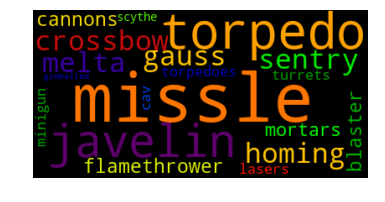

In [15]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(50):
    col = next(cmaps);
    display_cloud(i+1, col)

In [16]:
def get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]

In [24]:
get_word_table(model.wv.most_similar_cosmul(positive=['realist', 'woman'], negative=['man']), 'Analogy')

,Analogy,similarity
0,transgender,1.076207
1,normative,1.059378
2,feminist,1.026641
3,trans,1.024396
4,homosexual,1.024197
5,discriminatory,1.014411
6,asexuality,1.009015
7,polyamorous,1.001236
8,gender,0.995446
9,religious,0.991662


In [44]:
model.wv.most_similar_cosmul('king')

[('prince', 0.9056959748268127),
 ('queen', 0.8874455094337463),
 ('conqueror', 0.8814908862113953),
 ('emperor', 0.8745196461677551),
 ('regent', 0.8629422187805176),
 ('baratheon', 0.8586612939834595),
 ('targaryen', 0.8492510914802551),
 ('martell', 0.84911048412323),
 ('abdullah', 0.8467825651168823),
 ('lear', 0.8466910123825073)]

In [26]:
q = model['king'] - model['man'] + model['woman']
# q = model['king'] - model['man'] + model['woman']
get_word_table(model.wv.similar_by_vector(q), 'Analogy')

,Analogy,similarity
0,king,0.744034
1,queen,0.672159
2,regent,0.667036
3,daenerys,0.657089
4,targaryen,0.654082
5,tommen,0.649928
6,elizabeth,0.645340
7,prince,0.638281
8,consort,0.625215
9,aragorn,0.625053


In [27]:
model.wv.doesnt_match("apple microsoft samsung tesla".split())

'tesla'

In [28]:
model.wv.doesnt_match("trump clinton sanders obama".split())

'trump'

In [29]:
model.wv.doesnt_match("joffrey cersei tywin lannister jon".split())

'jon'

In [30]:
model.wv.doesnt_match("daenerys rhaegar viserion aemon aegon jon targaryen".split())

'viserion'

In [31]:
keys = ['musk', 'modi', 'hodor', 'martell', 'apple', 'neutrality', 'snowden', 'batman', 'hulk', 'warriors', 
        'falcons', 'pizza', ];
tables = [];
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key), key, show_sim=False))

In [32]:
pd.concat(tables, axis=1)

,musk,modi,hodor,martell,apple,neutrality,snowden,batman,hulk,warriors,falcons,pizza
0,elon,kejriwal,bran,baratheon,huawei,ttip,wikileaks,superman,aquaman,giants,broncos,burger
1,hawking,bjp,meera,targaryen,samsung,obamacare,cia,thor,superman,knights,jags,burrito
2,buffett,aap,bloodraven,greyjoy,microsoft,fcc,nsa,deadpool,thor,wizards,steelers,steak
3,tesla,netanyahu,theon,joffrey,motorola,sopa,greenwald,nightwing,batman,paladins,ravens,sushi
4,spacex,pawar,rickon,lannister,nokia,deregulation,fbi,wolverine,darkseid,warlocks,celtics,sandwich
5,braben,narendra,edmure,frey,cyanogen,regulation,assange,deathstroke,thanos,heros,packers,kfc
6,ula,arvind,daenerys,tully,android,reclassification,mossad,magneto,wolverine,rangers,cardinals,pho
7,northrop,obama,lightbringer,eddard,xiaomi,censorship,poroshenko,aquaman,punisher,titans,bucs,sausage
8,lockheed,bibi,mufasa,renly,sony,decentralization,gchq,joker,deathstroke,heroes,redskins,falafel
9,nikola,putin,requiem,arryn,blackberry,legalization,csis,spiderman,supes,kings,bruins,poutine


In [33]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [46]:
Z.shape

(74967, 100)

In [47]:
# project part of vocab, Z.shape dimension
w2v_sha = np.zeros(Z.shape)

In [57]:
with open("./projector/prefix_metadat.tsv", "w+") as file_metadata:
    for i, word in enumerate(model.wv.index2word[:Z.shape[0]]):
        w2v_sha[i] = model[word]
        file_metadata.write(word + '\n')
        


In [58]:
# define model
sess = tf.InteractiveSession()


In [59]:
with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v_sha, trainable=False, name="prefix_embedding")

tf.global_variables_initializer().run()
saver = tf.train.Saver()
writer = tf.summary.FileWriter("./projector", sess.graph)

In [60]:
# adding to the projector
config = projector.ProjectorConfig()
embed = config.embeddings.add()
embed.tensor_name = 'prefix_embedding:0'
embed.metadata_path = 'prefix_metadat.tsv'

In [61]:
# specifiy width and height of a single thumbnail
projector.visualize_embeddings(writer, config)
saver.save(sess, './projector/prefix_model.ckpt', global_step=Z.shape[0])


'./projector/prefix_model.ckpt-74967'